# PREDIÇÃO PARA CASOS CONFIRMADOS DE COVID

#### IMPORTAÇÕES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr

from pickle import dump

# IMPORT REDES NEURAIS
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
import warnings

#### FUNÇÕES

### Função para cálculo do Fator de 2

In [2]:
def get_fac2(y_true, y_pred):
    min_ = 0.5
    max_ = 2
    
    eps = np.finfo(np.float).eps
    
    division = y_pred / (y_true+eps)
    
    greater_min = np.greater_equal(division, min_)
    less_max = np.less_equal(division, max_)

    res = np.equal(greater_min, less_max)
    res = res.astype(float)

    fac_2 = res.mean()

    return fac_2

In [3]:
def plot_samples(y_true, y_pred, title='', xlabel='', ylabel='', filename="LSTM"):
    
    plt.figure(figsize=(14, 18))
    plt.suptitle(title, fontsize=14, y=0.915)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        days = list(range(col+1, (col+1)+len(y_true)))
        
        plt.subplot(8, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.plot(days, y_true.iloc[:, col], label='Real')
        plt.plot(days, y_pred.iloc[:, col], label='Previsão')
        plt.legend()
        plt.xlabel(xlabel, fontsize=10)
        plt.ylabel(ylabel, fontsize=10)
        plt.xlim(left=days[0], right=days[-1])
        plt.xticks(np.linspace(days[0], days[-1], num=5, dtype=int))
    plt.tight_layout()    
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
#     plt.savefig(filename +"_plot_samples.png", dpi=600)
    plt.show()
    
def plot_scatter(y_true, y_pred, title='', filename="LSTM"):
    
    plt.figure(figsize=(14, 18))
    plt.suptitle(title, fontsize=14, y=0.915)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        max_val = max(y_true.iloc[:, col].max(), y_pred.iloc[:, col].max())
        min_val = min(y_true.iloc[:, col].min(), y_pred.iloc[:, col].min())
                
        max_lim = max_val + max_val*0.05
        max_lim = math.ceil(max_lim)
        
        ndigits = len(str(max_lim))
        max_lim = int(math.ceil(max_lim / (10.0**(ndigits-2)) )) * (10.0**(ndigits-2))
        
        min_lim = min_val - max_val*0.05
        min_lim = max(0, min_lim)
        
        plt.subplot(8, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.scatter(y_true.iloc[:, col], y_pred.iloc[:, col])
        plt.xlabel('Real', fontsize=10)
        plt.ylabel('Previsão', fontsize=10)
        
        plt.xlim(left=min_lim, right=max_lim)
        plt.ylim(top=max_lim, bottom=min_lim)
        
        plt.xticks(np.linspace(min_lim, max_lim, num=5, dtype=int))
        plt.yticks(np.linspace(min_lim, max_lim, num=5, dtype=int))

        plt.plot([min_lim, max_lim], [min_lim, max_lim])
   
    plt.tight_layout()       
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
#     plt.savefig(filename + "_plot_scatter.png", dpi=600)
    plt.show()
    
def get_metrics(y_true, y_pred, filename="LSTM"):
    
    metrics = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'Pearson r', 'Fac2'])
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        y_true_col = y_true.iloc[:, col]
        y_pred_col = y_pred.iloc[:, col]

        if y_true_col.name == y_pred_col.name:
            col_name = y_true_col.name
        else:
            print('Column name error.')
            return None

        mse = mean_squared_error(y_true_col, y_pred_col)
        rmse = mean_squared_error(y_true_col, y_pred_col, squared=False)
        mae = mean_absolute_error(y_true_col, y_pred_col)
        pearson_r = pearsonr(y_true_col, y_pred_col)[0]
        fac2 = get_fac2(y_true_col.values, y_pred_col.values)
        metrics.loc[col_name, :] = [mse, rmse, mae, pearson_r, fac2]

    metrics.loc['Average', :] = metrics.mean()
#     metrics.to_csv("csv_metrics/" + filename + "_Metricas.csv",index=False)
    return metrics

def plot_metrics(dict_metrics, title='', xlabel='', ylabel='', filename="LSTM"):
    
    plt.figure(figsize=(14, 12))
    plt.suptitle(title, fontsize=14, y=0.935)
    
    keys = list(dict_metrics.keys())
    key_0 = keys[0]
    metrics_df_0 = dict_metrics[key_0]
    metrics_names = metrics_df_0.columns
    time_steps = list(range(1, metrics_df_0.shape[0]))
    
    for col, metric_name in enumerate(metrics_names):
        
        plt.subplot(3, 2, col+1)
        
        for key in dict_metrics.keys():
            
            metrics_df = dict_metrics[key]
            plt.plot(time_steps, metrics_df.iloc[0:-1, col], marker='o', label=key)
        
        plt.title('{} para cada horizonte de previsão'.format(metric_name))
        plt.legend()
        plt.xlabel('Dias a frente', fontsize=10)
        plt.ylabel(metric_name, fontsize=10)
        plt.xlim(left=time_steps[0], right=time_steps[-1])
        plt.xticks(np.linspace(time_steps[0], time_steps[-1], num=5, dtype=int))
        
        
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
#     plt.savefig(filename + "_plot_scatter.png", dpi=600)
    plt.show()

In [4]:
def generate_single_region_dataset(key, region_data, look_back, look_forward, x_columns, y_columns=None, gen_x=True, gen_y=True):
    
    # Check region dataframe
    if region_data is None:
        print('generate_single_region_dataset error: Region data is None!')
        return (None, None)
    
    # Check number of regions
    if len(region_data[key].unique()) > 1:
        print('generate_single_region_dataset error: More than one region in the dataframe!')
        return (None, None)
    else:
        region_name = region_data[key].unique()[0]
    
    # Drop 'Region' column
    region_data = region_data.drop(columns=key)
    
    # Check the number of samples available to
    # generate the look back and look forward windows
    if len(region_data) < (look_back + look_forward):
        print('generate_single_region_dataset error: Not enough samples '+
              'in {} to generate the windows!'.format(region_name))
        return (None, None)
    
    n_samples = len(region_data) - look_back - look_forward + 1

    var_names = x_columns
    
    # Generate inputs
    if gen_x:
        inputs = pd.DataFrame()
        
        for i in range(n_samples):
            input_window = region_data.T.iloc[:, i:i+look_back]
            wide_input_sample = pd.DataFrame()
            
            for var in var_names:
                var_input_sample = input_window.loc[var:var, :]
                var_input_sample.columns = ['{}_t{}'.format(var, a) for a in range(1-look_back, 1)]
                var_input_sample = var_input_sample.reset_index(drop=True)
                wide_input_sample = pd.concat([wide_input_sample, var_input_sample], axis='columns')
                
            inputs = pd.concat([inputs, wide_input_sample], axis='index')
            
        # Insert region name
        #inputs.insert(loc=0, column=key, value=region_name)
        # Reset index
        inputs = inputs.reset_index(drop=True)

    # Generate outputs
    if gen_y:
        
        if y_columns is None:
            print('generate_single_region_dataset error: Need to specify column labels!')
            return (None, None)
        
        var_names = y_columns
        outputs = pd.DataFrame()
        
        for i in range(n_samples):
            output_window = region_data.T.iloc[:, i+look_back : i+look_back+look_forward]
            wide_output_sample = pd.DataFrame()

            for var in var_names:
                var_output_sample = output_window.loc[var:var, :]
                var_output_sample.columns = ['{}_t+{}'.format(var, a) for a in range(1, look_forward+1)]
                var_output_sample = var_output_sample.reset_index(drop=True)
                wide_output_sample = pd.concat([wide_output_sample, var_output_sample], axis='columns')

            outputs = pd.concat([outputs, wide_output_sample], axis='index')
        
        # Insert region name
        #outputs.insert(loc=0, column=key, value=region_name)
        # Reset index
        outputs = outputs.reset_index(drop=True)
        
    if gen_x and gen_y:
        return (inputs, outputs)
    elif gen_x:
        return (inputs, None)
    elif gen_y:
        return (None, outputs)

In [5]:
def generate_regions_dataset(key, regions_data, look_back, look_forward, x_columns, y_columns=None, 
                             gen_x=True, gen_y=True):
    
    regions_names = regions_data[key].unique()
    
    all_regions_x = pd.DataFrame()
    all_regions_y = pd.DataFrame()
    
    for region_name in regions_names:
        
        region_data = regions_data[regions_data[key]==region_name]
        
        region_x, region_y = generate_single_region_dataset(key,
            region_data, look_back=look_back, look_forward=look_forward, x_columns=x_columns, y_columns=y_columns,
            gen_x=gen_x, gen_y=gen_y
        )
        
        if not (region_x is None):
            all_regions_x = pd.concat([all_regions_x, region_x])
            all_regions_x = all_regions_x.reset_index(drop=True)
            
        if not (region_y is None):
            all_regions_y = pd.concat([all_regions_y, region_y])
            all_regions_y = all_regions_y.reset_index(drop=True)
    
    if gen_x and gen_y:
        return (all_regions_x, all_regions_y)
    elif gen_x:
        return (all_regions_x, None)
    elif gen_y:
        return (None, all_regions_y)

In [6]:
lookback = 4
lookforward= 30

#### LEITURA DOS DADOS DO GRUPO

## TREINO, VALIDAÇÃO E TESTE

In [7]:
regions_train = pd.read_csv("../dataset/train_mundial_estadual_model_20200821.csv", sep="," , decimal=".")
regions_test = pd.read_csv("../dataset/test_mundial_estadual_model_20200821.csv", sep="," , decimal=".")
regions_val = pd.read_csv("../dataset/val_mundial_estadual_model_20200821.csv", sep="," , decimal=".")

In [8]:
x_columns = ["Deaths", "Confirmed", "C1","C2","C3","C4","C5","C6","C7","C8"]
y_columns = ["Confirmed"]

train_x, train_y = generate_regions_dataset("Country/Region", regions_train, lookback, lookforward, x_columns, y_columns=y_columns)
val_x, val_y = generate_regions_dataset("Country/Region", regions_val, lookback, lookforward, x_columns, y_columns=y_columns)
test_x, test_y = generate_regions_dataset("Country/Region", regions_test, lookback, lookforward, x_columns, y_columns=y_columns)

In [9]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_train_scaled = x_scaler.fit_transform(train_x)
x_test_scaled = x_scaler.transform(test_x)
x_val_scaled = x_scaler.transform(val_x)

y_train_scaled = y_scaler.fit_transform(train_y)
y_test_scaled = y_scaler.transform(test_y)
y_val_scaled = y_scaler.transform(val_y)

In [10]:
x_train_scaled = np.reshape(x_train_scaled, (x_train_scaled.shape[0],1, x_test_scaled.shape[1]))
x_test_scaled= np.reshape(x_test_scaled, (x_test_scaled.shape[0], 1, x_test_scaled.shape[1]))
x_val_scaled= np.reshape(x_val_scaled, (x_val_scaled.shape[0], 1, x_val_scaled.shape[1]))

In [11]:
#Arquitetura da RNA
activation = 'relu'
opt = optimizers.Adam(lr=1e-4)
tf.random.set_seed(0)

modelo = Sequential()
modelo.add(LSTM(units = 60, return_sequences = True, input_shape = (x_train_scaled.shape[1],x_train_scaled.shape[2] )))
modelo.add(LSTM(units = 60, return_sequences = True, activation="tanh",kernel_regularizer=tf.keras.regularizers.l2(0.01)))
modelo.add(Dropout(0.1))
modelo.add(LSTM(units = 60, activation = "tanh"))
modelo.add(Dense(units = lookforward, activation = "linear"))
modelo.compile(optimizer = opt, loss = 'mean_squared_error')

#Execução
history = modelo.fit(x_train_scaled, y_train_scaled,validation_data=(x_val_scaled, y_val_scaled), shuffle=False ,batch_size = 100, epochs = 300, verbose=0)

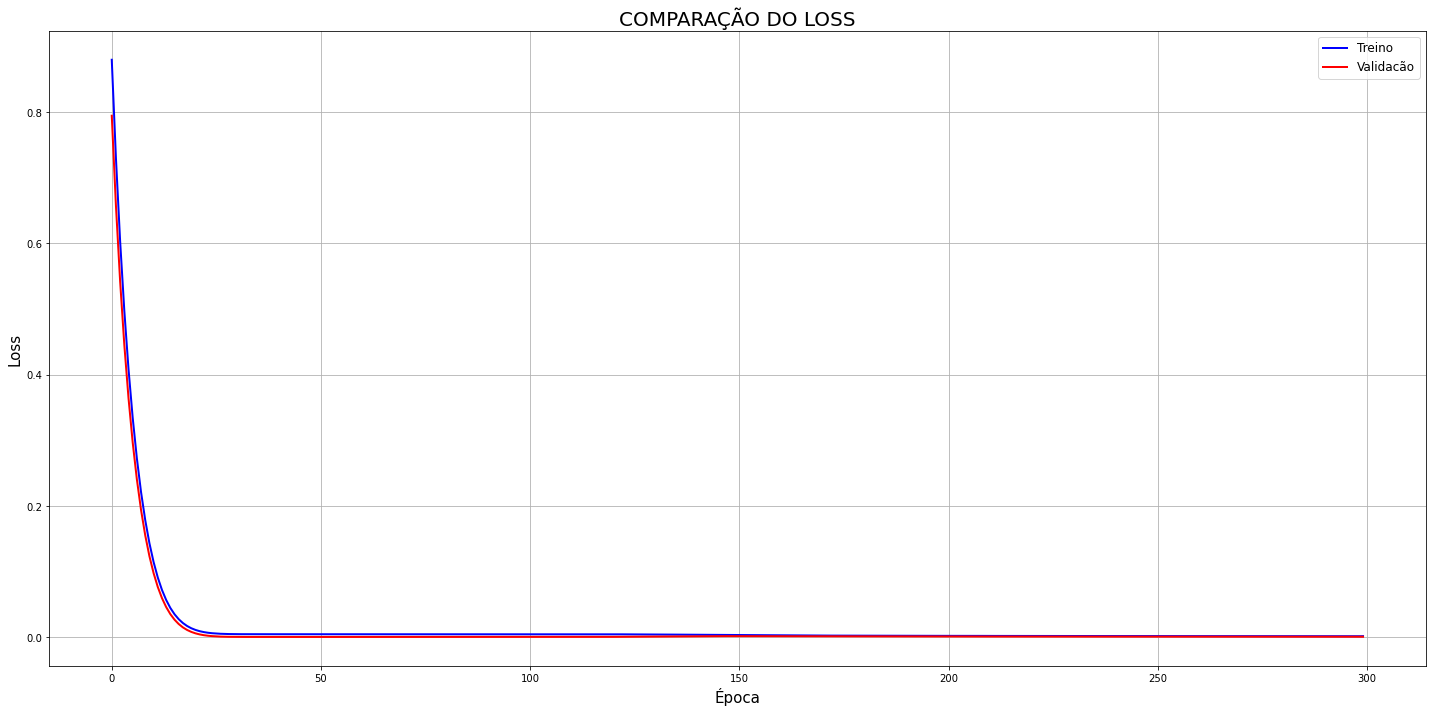

In [12]:
plt.figure(figsize=(20,10))

plt.plot(history.history['loss'], label = "Treino", linewidth =2, color ='blue')        
plt.plot(history.history['val_loss'],'-', label = "Validacão", linewidth =2, color='red')

plt.title('COMPARAÇÃO DO LOSS', fontsize =20)
plt.xlabel('Época', fontsize =15)
plt.ylabel('Loss',fontsize =15)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [13]:
warnings.filterwarnings('ignore')
y_train_pred =  modelo.predict(x_train_scaled) 
y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_train = y_scaler.inverse_transform(y_train_scaled)
y_train_pred = pd.DataFrame(y_train_pred)
y_train = pd.DataFrame(y_train)

train_metrics = get_metrics(y_train, y_train_pred)

In [14]:
warnings.filterwarnings('ignore')
y_test_pred =  modelo.predict(x_test_scaled) 
y_test_pred = y_scaler.inverse_transform(y_test_pred)
y_test = y_scaler.inverse_transform(y_test_scaled)
y_test_pred = pd.DataFrame(y_test_pred)
y_test = pd.DataFrame(y_test)

test_metrics = get_metrics(y_test, y_test_pred)

In [15]:
warnings.filterwarnings('ignore')
y_val_pred =  modelo.predict(x_val_scaled) 
y_val_pred = y_scaler.inverse_transform(y_val_pred)
y_val = y_scaler.inverse_transform(y_val_scaled)
y_val_pred = pd.DataFrame(y_val_pred)
y_val = pd.DataFrame(y_val)

val_metrics = get_metrics(y_val, y_val_pred)

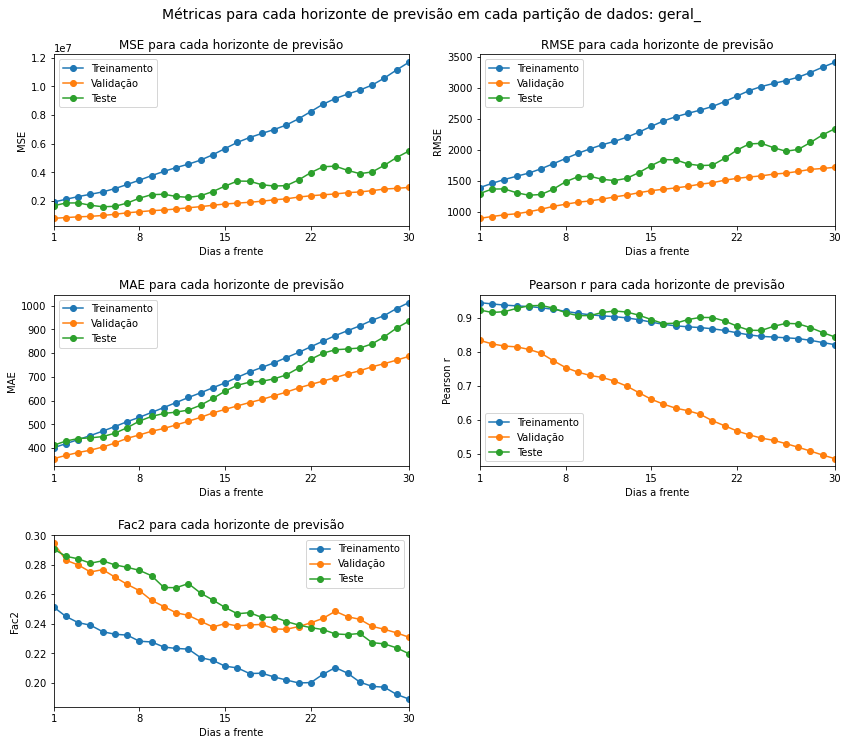

In [16]:
local="geral_"

dict_metrics = {
    'Treinamento': train_metrics,
    'Validação': val_metrics,
    'Teste': test_metrics
}
plot_metrics(
    dict_metrics,
    title='Métricas para cada horizonte de previsão em cada partição de dados: '+local,
    filename="LSTM_REAL"
)

## KFOLD

In [17]:
nome_arquivo_analise = "../dataset/complete_mundial_estadual_model_20200821.csv"

train_data = pd.read_csv(nome_arquivo_analise, sep="," , decimal=".")

In [18]:
x_columns = ["Deaths", "Confirmed", "C1","C2","C3","C4","C5","C6","C7","C8"]
y_columns = ["Confirmed"]

train_x, train_y = generate_regions_dataset("Country/Region", train_data, lookback, lookforward, x_columns, y_columns=y_columns)

In [19]:
train_x = train_x.to_numpy(dtype=float)
train_y = train_y.to_numpy(dtype=float)

In [20]:
warnings.filterwarnings('ignore')

kfold = KFold(n_splits=5, shuffle=True)
MSEscores = []
RMSEscores = []
MAEscores = []
FACscores = []
Rscores = []

num_k = 0
for train, test in kfold.split(train_x, train_y):
    #Arquitetura da RNA
    normalizador_kfold = MinMaxScaler(feature_range=(0, 1))
    kfold_train = normalizador_kfold.fit_transform(train_x[train])
    
    normalizador_kfold_y = MinMaxScaler(feature_range=(0, 1))
    y_kfold_train = normalizador_kfold_y.fit_transform(train_y[train])
    
    kfold_test = normalizador_kfold.transform(train_x[test])
    y_kfold_test = normalizador_kfold_y.transform(train_y[test])
    
    new_kfold_train = np.empty([kfold_train.shape[0], 1, kfold_train.shape[1]])
    new_kfold_test = np.empty([kfold_test.shape[0], 1,kfold_train.shape[1]])

    k = 0
    for i in range(1):
        for j in range(kfold_train.shape[1]):
            new_kfold_train[:, i, j] = kfold_train[:, k]
            new_kfold_test[:, i, j] = kfold_test[:, k]
            k = k + 1
            
    kfold_train = new_kfold_train
    kfold_test = new_kfold_test
    
    #Arquitetura da RNA
    activation = 'relu'
    opt = optimizers.Adam(lr=1e-4)
    tf.random.set_seed(0)

    modelo = Sequential()
    modelo.add(LSTM(units = 60, return_sequences = True, input_shape = (new_kfold_train.shape[1],new_kfold_train.shape[2] )))
    modelo.add(LSTM(units = 60, return_sequences = True, activation="tanh",kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    modelo.add(Dropout(0.1))
    modelo.add(LSTM(units = 60, activation = "tanh"))
    modelo.add(Dense(units = lookforward, activation = "linear"))
    modelo.compile(optimizer = opt, loss = 'mean_squared_error')

    #Execução
    
    modelo.fit(kfold_train, y_kfold_train, shuffle=False,batch_size = 100, epochs = 300, verbose=0)
    
    observado = y_kfold_test
    predicao =  modelo.predict(kfold_test)
    predicao = normalizador_kfold_y.inverse_transform(predicao)
    observado = normalizador_kfold_y.inverse_transform(observado)
    
    metricas_qualidade = get_metrics(pd.DataFrame(observado), pd.DataFrame(predicao), filename="K_FOLD_SEM_INFERENCIA_CONFIRMED_LSTMCNN")
    MSE = metricas_qualidade["MSE"].mean()
    RMSE = metricas_qualidade["RMSE"].mean()
    MAE = metricas_qualidade["MAE"].mean()
    R = metricas_qualidade["Pearson r"].mean()
    FAC2 = metricas_qualidade["Fac2"].mean()
    
    print("K: " + str(num_k))
    print("MSE: ", MSE)
    print("RMSE: ", RMSE)
    print("MAE: ", MAE)
    print("R: ", R)
    print("FAC2: ", FAC2)
    print("-----------------------------------")
    MSEscores.append(MSE)
    RMSEscores.append(RMSE)
    MAEscores.append(MAE)
    Rscores.append(R)
    FACscores.append(FAC2)
    num_k = num_k + 1
    
print("RESULTS K-FOLD: ")
print("MSE: " + str(np.mean(MSEscores)) + " +/- " +  str(np.std(MSEscores)))
print("RMSE: " + str(np.mean(RMSEscores)) + " +/- " +  str(np.std(RMSEscores)))
print("MAE: " + str(np.mean(MAEscores)) + " +/- " +  str(np.std(MAEscores)))
print("R: " + str(np.mean(Rscores)) + " +/- " +  str(np.std(Rscores)))
print("FAC2: " + str(np.mean(FACscores)) + " +/- " +  str(np.std(FACscores)))

K: 0
MSE:  2855709.173187841
RMSE:  1641.1486208983822
MAE:  598.554113056442
R:  0.9224424143289301
FAC2:  0.19773765499238635
-----------------------------------
K: 1
MSE:  3047119.629137729
RMSE:  1697.2159348813868
MAE:  635.8565457244573
R:  0.9218887856674272
FAC2:  0.18052352983830036
-----------------------------------
K: 2
MSE:  3245119.1756207487
RMSE:  1746.765496916037
MAE:  622.2862090478217
R:  0.9208973892354354
FAC2:  0.18266260604742227
-----------------------------------
K: 3
MSE:  2756370.301410311
RMSE:  1601.8025000100329
MAE:  569.664621909177
R:  0.9325683433411396
FAC2:  0.2132187658617939
-----------------------------------
K: 4
MSE:  4155961.092759531
RMSE:  1977.8376713525327
MAE:  709.0210810120923
R:  0.9063690458687294
FAC2:  0.1702059762111981
-----------------------------------
RESULTS K-FOLD: 
MSE: 3212055.874423232 +/- 500776.70094182953
RMSE: 1732.9540448116743 +/- 131.95826826855466
MAE: 627.076514149998 +/- 46.74312944262506
R: 0.9208331956883322 +/

## TREINAMENTO DADOS COMPLETOS

In [21]:
normalizador = MinMaxScaler(feature_range=(0, 1))
norm_dados_treino_full = normalizador.fit_transform(train_x)

new_train = np.empty([norm_dados_treino_full.shape[0], 1, norm_dados_treino_full.shape[1]])

k = 0
for i in range(1):
    for j in range(norm_dados_treino_full.shape[1]):
        new_train[:, i, j] = norm_dados_treino_full[:, k]
        k = k + 1
        
normalizador_y = MinMaxScaler(feature_range=(0, 1))
y_train = normalizador_y.fit_transform(train_y)

In [22]:
dump(normalizador, open('Normalizador_Preditores_LSTM_REAL_CONFIRMADOS.pkl', 'wb'))
dump(normalizador_y, open('Normalizador_Target_LSTM_REAL_CONFIRMADOS.pkl', 'wb'))

In [23]:
#Arquitetura da RNA
activation = 'relu'
opt = optimizers.Adam(lr=1e-4)
tf.random.set_seed(0)

modelo = Sequential()
modelo.add(LSTM(units = 60, return_sequences = True, input_shape = (new_train.shape[1],new_train.shape[2] )))
modelo.add(LSTM(units = 60, return_sequences = True, activation="linear",kernel_regularizer=tf.keras.regularizers.l2(0.01)))
modelo.add(Dropout(0.1))
modelo.add(LSTM(units = 60, activation = "tanh"))
modelo.add(Dense(units = lookforward, activation = "linear"))
modelo.compile(optimizer = opt, loss = 'mean_squared_error')

#Execução
history = modelo.fit(new_train, y_train, shuffle=False,batch_size = 100, epochs = 300, verbose=1)

Train on 22984 samples
Epoch 1/300
22984/22984 [==============================] - 6s 281us/sample - loss: 0.7582
Epoch 2/300
22984/22984 [==============================] - 2s 106us/sample - loss: 0.4558
Epoch 3/300
22984/22984 [==============================] - 2s 104us/sample - loss: 0.2667
Epoch 4/300
22984/22984 [==============================] - 3s 109us/sample - loss: 0.1507
Epoch 5/300
22984/22984 [==============================] - 2s 107us/sample - loss: 0.0818
Epoch 6/300
22984/22984 [==============================] - 2s 107us/sample - loss: 0.0426
Epoch 7/300
22984/22984 [==============================] - 2s 107us/sample - loss: 0.0215
Epoch 8/300
22984/22984 [==============================] - 3s 109us/sample - loss: 0.0108
Epoch 9/300
22984/22984 [==============================] - 2s 106us/sample - loss: 0.0058
Epoch 10/300
22984/22984 [==============================] - 2s 108us/sample - loss: 0.0036
Epoch 11/300
22984/22984 [==============================] - 2s 104us/sample 

In [24]:
modelo.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 1, 60)             24240     
_________________________________________________________________
lstm_19 (LSTM)               (None, 1, 60)             29040     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 60)             0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dense_6 (Dense)              (None, 30)                1830      
Total params: 84,150
Trainable params: 84,150
Non-trainable params: 0
_________________________________________________________________


#### SALVANDO O MODELO

In [25]:
modelo.save('FULL_DATASET_CONFIRMED_Modelo_LSTM_REAL.h5')

#### VERIFICAÇÃO DO LOSS

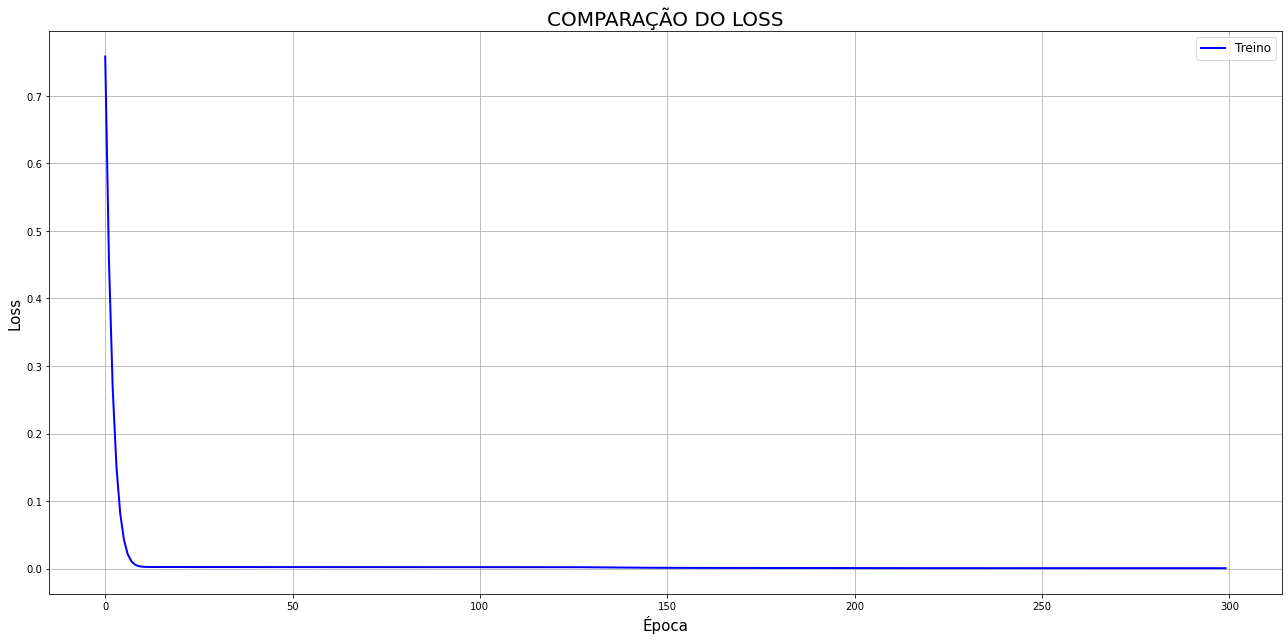

In [26]:
plt.figure(figsize=(18,9))

plt.plot(history.history['loss'], label = "Treino", linewidth =2, color ='blue')        

plt.title('COMPARAÇÃO DO LOSS', fontsize =20)
plt.xlabel('Época', fontsize =15)
plt.ylabel('Loss',fontsize =15)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [27]:
lb_test = "TRAIN"

if lb_test == "TRAIN":
    observado = y_train
    predicao =  modelo.predict(new_train) 
elif lb_test == "VAL":
    observado = y_val
    predicao =  modelo.predict(new_val) 
elif lb_test == "TEST":
    observado = y_test
    predicao =  modelo.predict(new_test) 

In [28]:
observado = y_train
predicao =  modelo.predict(new_train) 
predicao = normalizador_y.inverse_transform(predicao)
observado = normalizador_y.inverse_transform(observado)

#### AVALIAÇÃO DO MODELO POR HORIZONTE DE PREDIÇÃO

In [29]:
metricas_qualidade = get_metrics(pd.DataFrame(observado), pd.DataFrame(predicao), filename=lb_test + "CONFIRMED_LSTM_REAL")
metricas_qualidade

,MSE,RMSE,MAE,Pearson r,Fac2
0,1.50959e+06,1228.65,440.145,0.967632,0.245997
1,1.56385e+06,1250.54,440.073,0.964604,0.242386
2,1.5925e+06,1261.94,449.957,0.964764,0.243996
3,1.5939e+06,1262.5,462.66,0.967511,0.246606
4,1.62947e+06,1276.51,473.185,0.968155,0.243865
5,1.73055e+06,1315.5,486.846,0.9663,0.241385
6,1.89182e+06,1375.44,497.187,0.960402,0.237078
7,2.06346e+06,1436.47,504.499,0.952454,0.230987
8,2.21415e+06,1488,515.857,0.947093,0.228159
9,2.27962e+06,1509.84,523.258,0.944796,0.228115


## BRASIL

In [30]:
 brazil = train_data[train_data['Country/Region'] == 'Brazil'].copy()
x_brazil, y_brazil = generate_regions_dataset(
    key="Country/Region",
    regions_data=brazil,
    look_back=lookback,
    look_forward=lookforward,
    x_columns=x_columns,
    y_columns=y_columns
)

In [31]:
local="Brasil_"
x_brazil_scaled = normalizador.transform(x_brazil)
y_brazil_scaled = normalizador_y.transform(y_brazil)

x_brazil_scaled = np.reshape(x_brazil_scaled, (x_brazil_scaled.shape[0], 1, x_brazil_scaled.shape[1]))

y_brazil_pred = modelo.predict(x_brazil_scaled)
y_brazil_pred = normalizador_y.inverse_transform(y_brazil_pred)

y_brazil = normalizador_y.inverse_transform(y_brazil_scaled)

y_brazil_pred = pd.DataFrame(y_brazil_pred)
y_brazil = pd.DataFrame(y_brazil)

brazil_metrics = get_metrics(y_brazil, y_brazil_pred)
brazil_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,8.49938e+07,9219.21,5215.2,0.912119,0.736842
1,9.42591e+07,9708.71,5317.97,0.895402,0.706767
2,9.3839e+07,9687.06,5523.18,0.901478,0.729323
3,8.41481e+07,9173.23,5511.34,0.925021,0.789474
4,7.81079e+07,8837.87,5439.97,0.93989,0.81203
5,7.76315e+07,8810.87,5375.92,0.943769,0.81203
6,8.83728e+07,9400.68,5398.33,0.926309,0.774436
7,1.05591e+08,10275.8,5787.02,0.894044,0.75188
8,1.17141e+08,10823.2,6094.61,0.875654,0.759398
9,1.17607e+08,10844.7,6251.11,0.877005,0.729323


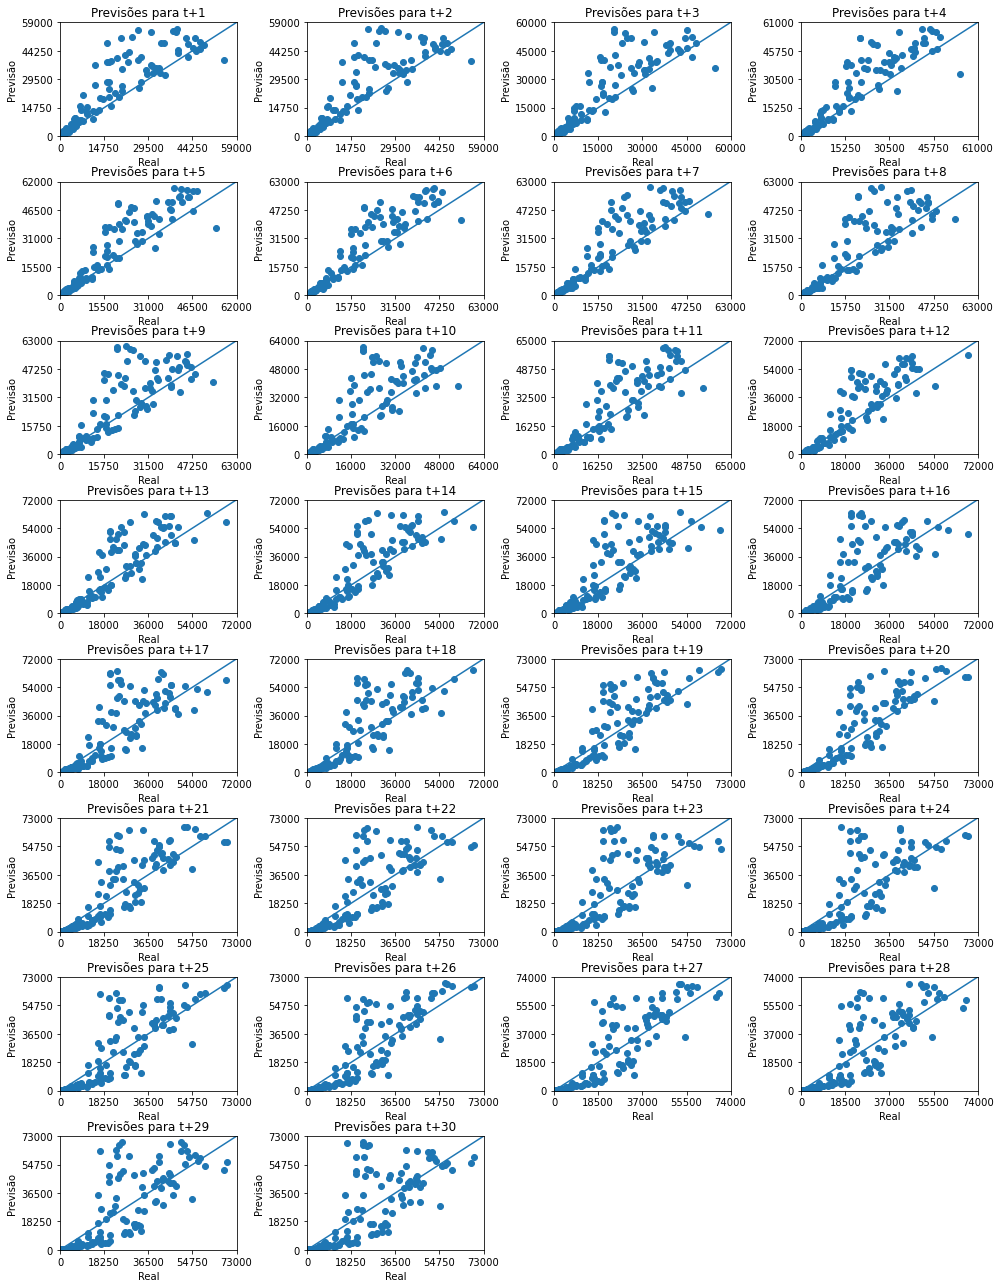

In [32]:
plot_scatter(
    y_brazil,
    y_brazil_pred,
    )

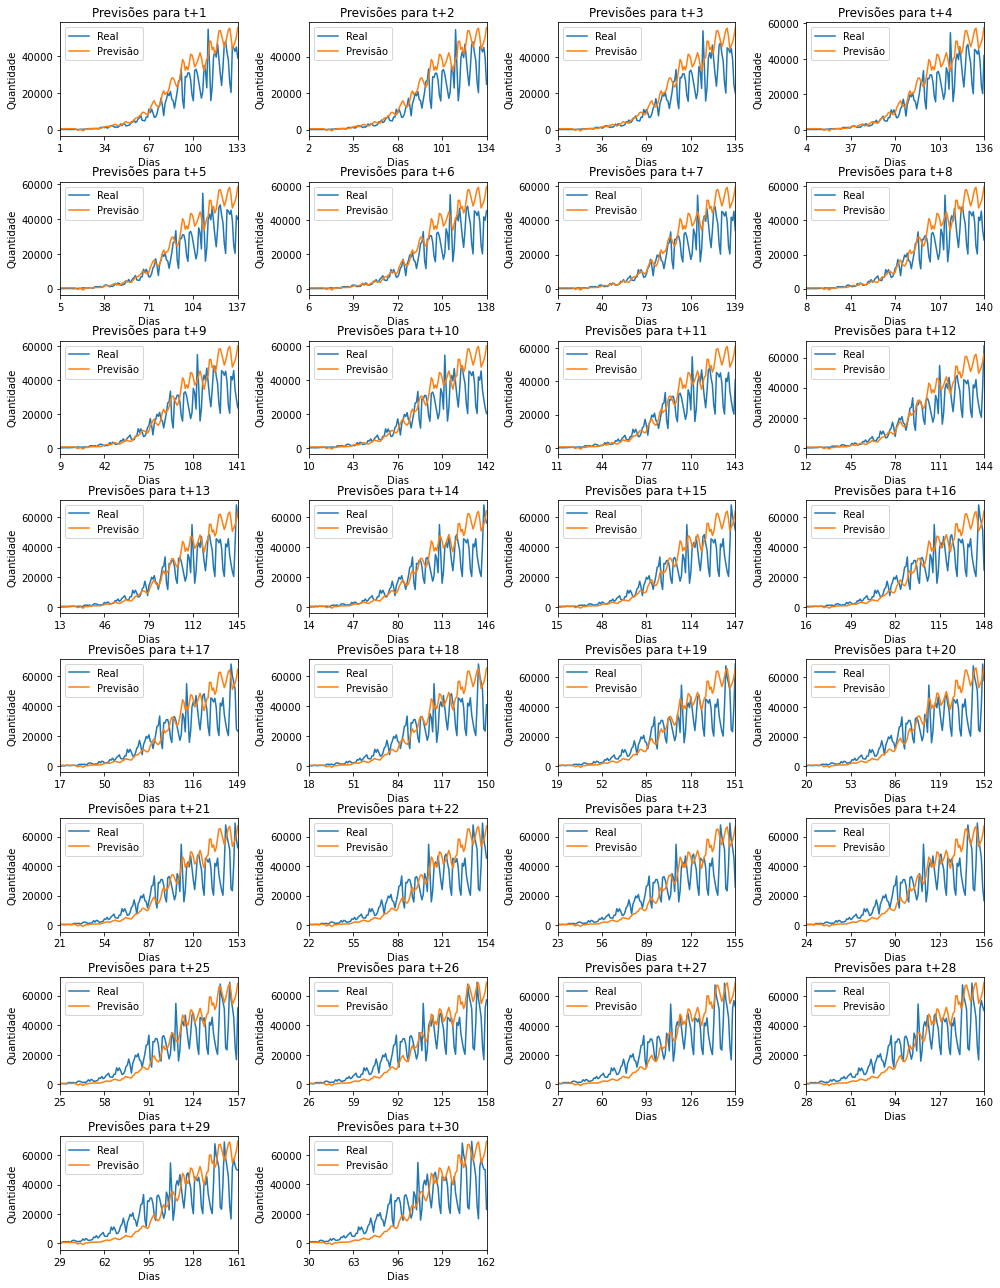

In [33]:
plot_samples(
    y_brazil,
    y_brazil_pred,
   
    xlabel='Dias',
    ylabel='Quantidade'
)

## BAHIA

In [34]:
 bahia = train_data[train_data['Country/Region'] == 'BA'].copy()
x_bahia, y_bahia = generate_regions_dataset(
    key="Country/Region",
    regions_data=bahia,
    look_back=lookback,
    look_forward=lookforward,
    x_columns=x_columns,
    y_columns=y_columns
)

In [35]:
local="Bahia_"
x_bahia_scaled = normalizador.transform(x_bahia)
y_bahia_scaled = normalizador_y.transform(y_bahia)

x_bahia_scaled = np.reshape(x_bahia_scaled, (x_bahia_scaled.shape[0], 1, x_bahia_scaled.shape[1]))

y_bahia_pred = modelo.predict(x_bahia_scaled)
y_bahia_pred = normalizador_y.inverse_transform(y_bahia_pred)

y_bahia = normalizador_y.inverse_transform(y_bahia_scaled)

y_bahia_pred = pd.DataFrame(y_bahia_pred)
y_bahia = pd.DataFrame(y_bahia)

bahia_metrics = get_metrics(y_bahia, y_bahia_pred)
bahia_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,1.13191e+06,1063.91,663.08,0.705841,0.385185
1,1.25334e+06,1119.53,657.374,0.678825,0.407407
2,1.18348e+06,1087.88,653.304,0.705391,0.42963
3,1.16561e+06,1079.63,659.713,0.717246,0.42963
4,1.15477e+06,1074.6,646.503,0.723904,0.451852
5,1.22569e+06,1107.11,652.095,0.71097,0.466667
6,1.27496e+06,1129.14,679.778,0.703263,0.466667
7,1.43438e+06,1197.66,731.659,0.664932,0.474074
8,1.52963e+06,1236.78,760.676,0.646787,0.422222
9,1.46386e+06,1209.9,783.34,0.668107,0.437037


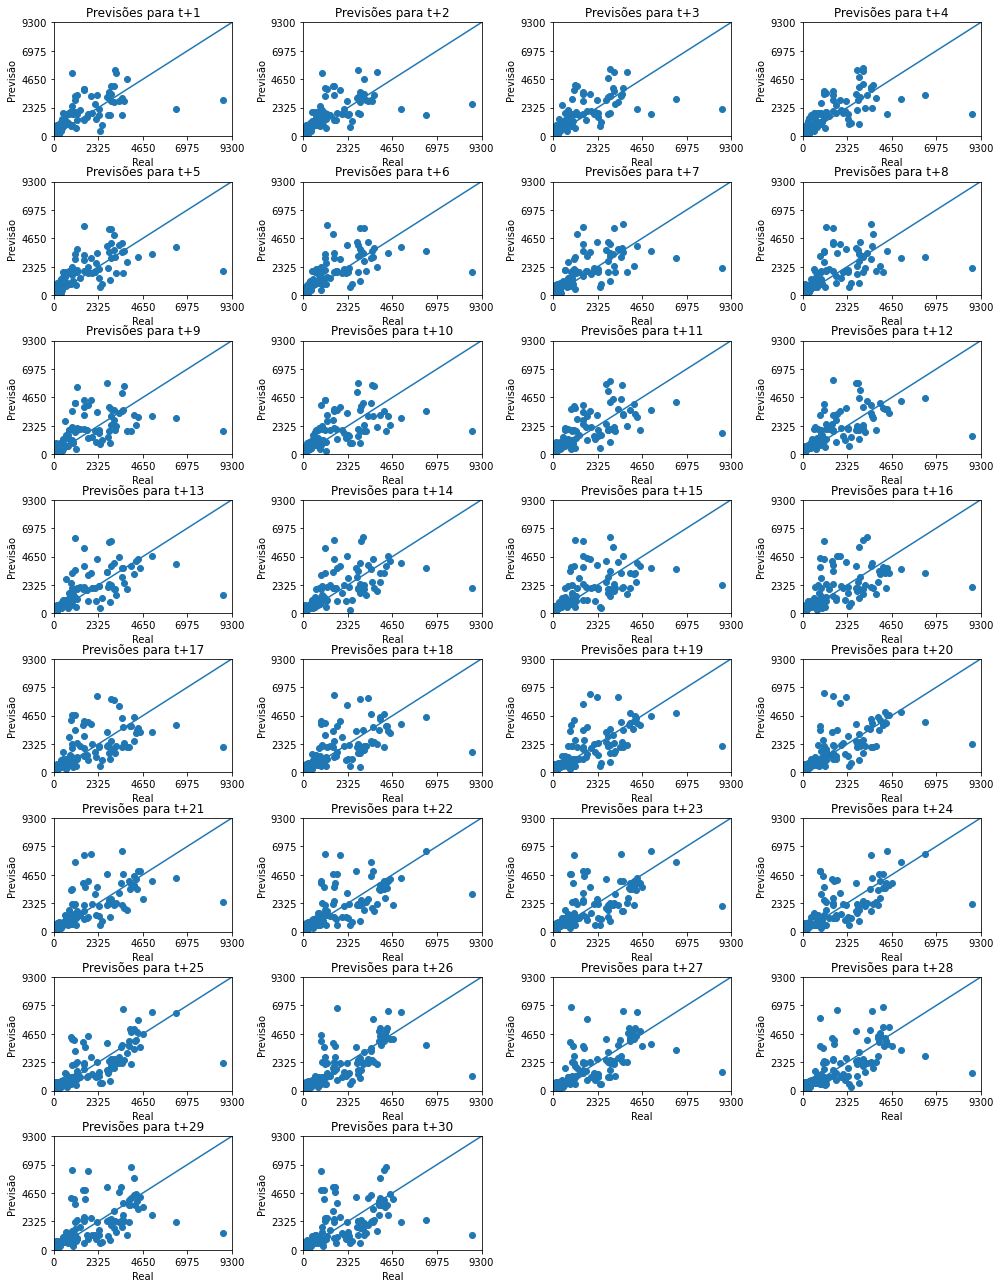

In [36]:
plot_scatter(
    y_bahia,
    y_bahia_pred,
   
)

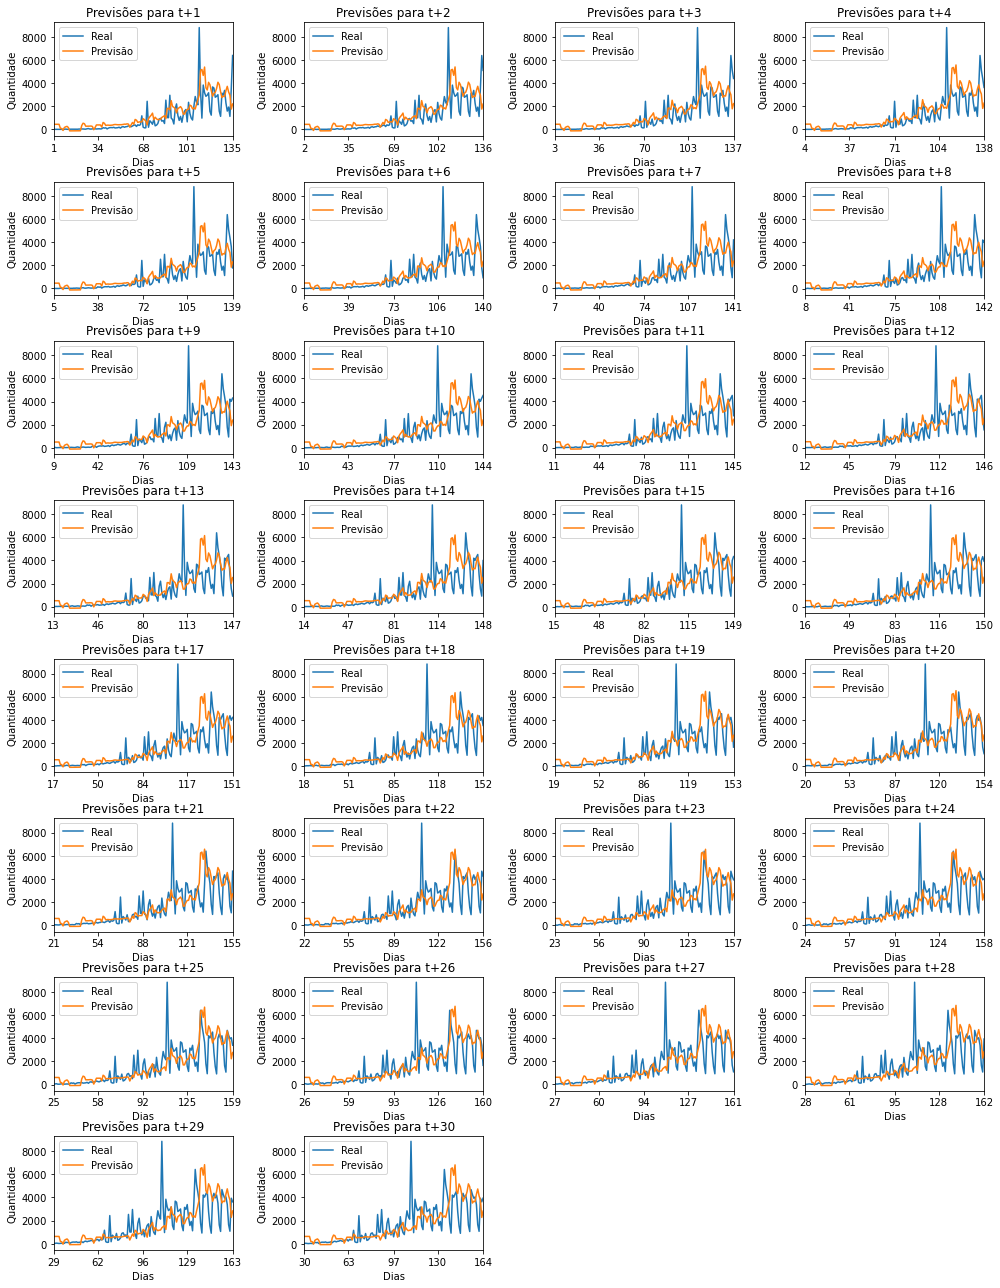

In [37]:
plot_samples(
    y_bahia,
    y_bahia_pred,
    
    xlabel='Dias',
    ylabel='Quantidade'
)